# First attempt of clustering the publications from Science Mag.

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 100)

import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# We have to define, which words we need to add
stop_words = set(ENGLISH_STOP_WORDS)
stop_words.add('said')
ENGLISH_STOP_WORDS = frozenset(stop_words)

import pickle



# Have check these to out
from numba import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, config
config.THREADING_LAYER = 'threadsafe'
from umap import UMAP
from collections import defaultdict
import re
import plotly.graph_objects as go
import plotly.io as pio
from typing import List, Union

from bertopic import BERTopic


/home/linuxuser/spiced-academy/data_science_capstone/convergence_oracle/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-20 23:59:39.171356: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 23:59:40.339225: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 23:59:40.347532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 23:59:44.249473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Coul

In [11]:
# Loading the data set
df = pd.read_csv("./data/1880-2023_Science_48966.csv")
display(df.T)

,0,1,2,3,4,5,6,7,8,9,...,48956,48957,48958,48959,48960,48961,48962,48963,48964,48965
paperId,1ae8fdc58a9c0406cdf57fd1581818b20bb5881d,db452fdc77a9402dc02e933dc6d6271d1925ecd1,1ca21635c829debae169bfe673646fe766fb9127,7a922fec3f049f4c9106eff0a215bd9e4d51b3cd,492b59caa7305dbc0dae4b179fe563e9ba50b09d,70084a72e2851e3a6a8b3dee203ed2a82700dab3,8fbc9eb50ca8c746c16318eabd3199eddfd3daad,380596d5e4964b955cad9e3f27df580ffc97fa88,53e8e5e449b7fb107084e25f6693000d67fe68d8,b9c72a626e6978f69c019f1e28b26f1111e1e332,...,d55f08a6917b29319300b87d66c2afb7fab09417,87e0037bb23543c834d326333dd258082516bc15,6c3340e0fb13d17db3468b92c5a04aab67b1375d,1fe75303cb88f254d7bbc93760b0c0d41d69b7cd,a83b06db77b3eb10deea56adcfebaf8b06406fec,04ae65223d107ff1d711ed1d841a807a1eb63212,d6a85b034d4fc3d2d829957201c917c0275f5f6f,4c8c25a911bdbd47d991fc3afe717965dcec93ce,fbcf4c738a43ea5e90e79a18350508d3c09c3847,8072dfc3c1e4db574fcbd4b49680a569e242d657
title,Sensing Chromosome Bi-Orientation by Spatial Separation of Aurora B Kinase from Kinetochore Subs...,Controlled Formation of Sharp Zigzag and Armchair Edges in Graphitic Nanoribbons,The Fanconi Anemia Pathway Promotes Replication-Dependent DNA Interstrand Cross-Link Repair,The Earliest Horse Harnessing and Milking,Soil Microbial Communities and Restoration Ecology: Facilitators or Followers?,A Vital Role for Interleukin-21 in the Control of a Chronic Viral Infection,H2O at the Phoenix Landing Site,A Radio Pulsar/X-ray Binary Link,Amplified Trace Gas Removal in the Troposphere,"Giant-Stroke, Superelastic Carbon Nanotube Aerogel Muscles",...,"Anatomy of the Honey Bee\n . R. E. Snodgrass. Comstock (Cornell University Press), Ithaca, N.Y.,...","Advances in Veterinary Science\n . vol. II. C. A. Brandly and E. L. Jungherr. Academic Press, Ne...",Gmelins Handbuch der Anorganischen Chemie\n . vol. 44.\n Thorium and Isotopes\n . Edited by Gmel...,"Expanding Universes\n . E. Schrodinger. Cambridge University Press, Cambridge, 1956. 93 pp. 10 i...","Chemistry of the Soil\n . Firman E. Bear, Ed. Reinhold, New York, 1955. x + 373 pp. Illus. $8.75.",The Fossil Evidence for Human Evolution\n . An introduction to the study of paleoanthropology. W...,"E. C. Crittenden, Physical Standards Expert.","R. E. Clausen, geneticist.",Volatility of Metallo-Porphyrin Complexes,"Advances in Geophysics\n . vol. 2. H. E. Landsberg, Ed. Academic Press, New York, 1955. x + 286 ..."
abstract,Successful cell division requires that chromosomes attach to opposite poles of the mitotic spind...,"Graphene nanoribbons can exhibit either quasi-metallic or semiconducting behavior, depending on ...",Fanconi Cross-Links Fanconi anemia is a rare genetic disease characterized by bone marrow failur...,"Horse domestication revolutionized transport, communications, and warfare in prehistory, yet the...","Microorganisms have critical roles in the functioning of soil in nutrient cycling, structural fo...",Controlling Chronic Viral Infections Chronic viral infections such as HIV and hepatitis B and C ...,Phoenix Ascending The Phoenix mission landed on Mars in March 2008 with the goal of studying the...,From X-ray Binary to Pulsar Pulsars with millisecond rotational periods are thought to originate...,Going Faster The concentrations of most tropospheric pollutants and trace gases are kept in chec...,"Improved electrically powered artificial muscles are needed for generating force, moving objects...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,2009,2009,2009,2009,2009,2009,2009,2009,2009,2009,...,1956,1956,1956,1956,1956,1956,1956,1956,1956,1956
referenceCount,47,31,23,16,22,35,23,36,34,21,...,0,0,0,0,0,0,0,0,15,0
citationCount,491,543,507,526,485,523,526,429,477,498,...,0,0,0,0,0,1,0,0,2,0
influentialCitationCount,38,7,34,33,24,19,19,69,24,4,...,0,0,0,0,0,0,0,0,0,0
fieldsOfStudy,"['Biology', 'Medicine']","['Materials Science', 'Medicine']","['Biology', 'Medicine']","['Geography', 'Medicine']","['Biology', 'Medicine']","['Biology', 'Medicine']","['Environmental Science', 

In [12]:
columns_to_drop=['paperId','paperId','s2FieldsOfStudy','MAG','DOI','CorpusId','ArXiv','DBLP','PubMed','PubMedCentral','id','issn','alternate_issns','alternate_urls','type','publicationTypes','url']
df_c = df.drop(columns=columns_to_drop,axis=1)
display(df_c.T)

,0,1,2,3,4,5,6,7,8,9,...,48956,48957,48958,48959,48960,48961,48962,48963,48964,48965
title,Sensing Chromosome Bi-Orientation by Spatial Separation of Aurora B Kinase from Kinetochore Subs...,Controlled Formation of Sharp Zigzag and Armchair Edges in Graphitic Nanoribbons,The Fanconi Anemia Pathway Promotes Replication-Dependent DNA Interstrand Cross-Link Repair,The Earliest Horse Harnessing and Milking,Soil Microbial Communities and Restoration Ecology: Facilitators or Followers?,A Vital Role for Interleukin-21 in the Control of a Chronic Viral Infection,H2O at the Phoenix Landing Site,A Radio Pulsar/X-ray Binary Link,Amplified Trace Gas Removal in the Troposphere,"Giant-Stroke, Superelastic Carbon Nanotube Aerogel Muscles",...,"Anatomy of the Honey Bee\n . R. E. Snodgrass. Comstock (Cornell University Press), Ithaca, N.Y.,...","Advances in Veterinary Science\n . vol. II. C. A. Brandly and E. L. Jungherr. Academic Press, Ne...",Gmelins Handbuch der Anorganischen Chemie\n . vol. 44.\n Thorium and Isotopes\n . Edited by Gmel...,"Expanding Universes\n . E. Schrodinger. Cambridge University Press, Cambridge, 1956. 93 pp. 10 i...","Chemistry of the Soil\n . Firman E. Bear, Ed. Reinhold, New York, 1955. x + 373 pp. Illus. $8.75.",The Fossil Evidence for Human Evolution\n . An introduction to the study of paleoanthropology. W...,"E. C. Crittenden, Physical Standards Expert.","R. E. Clausen, geneticist.",Volatility of Metallo-Porphyrin Complexes,"Advances in Geophysics\n . vol. 2. H. E. Landsberg, Ed. Academic Press, New York, 1955. x + 286 ..."
abstract,Successful cell division requires that chromosomes attach to opposite poles of the mitotic spind...,"Graphene nanoribbons can exhibit either quasi-metallic or semiconducting behavior, depending on ...",Fanconi Cross-Links Fanconi anemia is a rare genetic disease characterized by bone marrow failur...,"Horse domestication revolutionized transport, communications, and warfare in prehistory, yet the...","Microorganisms have critical roles in the functioning of soil in nutrient cycling, structural fo...",Controlling Chronic Viral Infections Chronic viral infections such as HIV and hepatitis B and C ...,Phoenix Ascending The Phoenix mission landed on Mars in March 2008 with the goal of studying the...,From X-ray Binary to Pulsar Pulsars with millisecond rotational periods are thought to originate...,Going Faster The concentrations of most tropospheric pollutants and trace gases are kept in chec...,"Improved electrically powered artificial muscles are needed for generating force, moving objects...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,2009,2009,2009,2009,2009,2009,2009,2009,2009,2009,...,1956,1956,1956,1956,1956,1956,1956,1956,1956,1956
referenceCount,47,31,23,16,22,35,23,36,34,21,...,0,0,0,0,0,0,0,0,15,0
citationCount,491,543,507,526,485,523,526,429,477,498,...,0,0,0,0,0,1,0,0,2,0
influentialCitationCount,38,7,34,33,24,19,19,69,24,4,...,0,0,0,0,0,0,0,0,0,0
fieldsOfStudy,"['Biology', 'Medicine']","['Materials Science', 'Medicine']","['Biology', 'Medicine']","['Geography', 'Medicine']","['Biology', 'Medicine']","['Biology', 'Medicine']","['Environmental Science', 'Medicine']","['Medicine', 'Physics']","['Chemistry', 'Medicine']","['Materials Science', 'Medicine']",...,NaN,NaN,NaN,NaN,NaN,NaN,"['Engineering', 'Medicine']","['Philosophy', 'Medicine']",NaN,NaN
publicationDate,2009-03-06,2009-03-27,2009-12-18,2009-03-06,2009-07-31,2009-06-19,2009-07-03,2009-05-20,2009-06-26,2009-03-20,...,1956-10-19,1956-06-08,1956-09-14,1956-08-24,1956-03-30,1956-04-06,1956-08-10,1956-12-28,1956-03-23,1956-06-15
name,Science,Science,Science,Science,Science,Science,Science,Science,Science,Science,...,Science,Science,Science,Science,Science,Science,Science,Science,Science,Science


In [13]:
def clean_text(row):
    # Combine title and text
    combined_text = str(row['title']) + '. ' + str(row['abstract'])
    # Tokenize and remove stopwords
    cleaned_tokens = [word for word in combined_text.split() if word.lower() not in ENGLISH_STOP_WORDS]
    return ' '.join(cleaned_tokens)

df_c['title_abstract'] = df_c.apply(clean_text, axis=1)
display(df_c.T)

,0,1,2,3,4,5,6,7,8,9,...,48956,48957,48958,48959,48960,48961,48962,48963,48964,48965
title,Sensing Chromosome Bi-Orientation by Spatial Separation of Aurora B Kinase from Kinetochore Subs...,Controlled Formation of Sharp Zigzag and Armchair Edges in Graphitic Nanoribbons,The Fanconi Anemia Pathway Promotes Replication-Dependent DNA Interstrand Cross-Link Repair,The Earliest Horse Harnessing and Milking,Soil Microbial Communities and Restoration Ecology: Facilitators or Followers?,A Vital Role for Interleukin-21 in the Control of a Chronic Viral Infection,H2O at the Phoenix Landing Site,A Radio Pulsar/X-ray Binary Link,Amplified Trace Gas Removal in the Troposphere,"Giant-Stroke, Superelastic Carbon Nanotube Aerogel Muscles",...,"Anatomy of the Honey Bee\n . R. E. Snodgrass. Comstock (Cornell University Press), Ithaca, N.Y.,...","Advances in Veterinary Science\n . vol. II. C. A. Brandly and E. L. Jungherr. Academic Press, Ne...",Gmelins Handbuch der Anorganischen Chemie\n . vol. 44.\n Thorium and Isotopes\n . Edited by Gmel...,"Expanding Universes\n . E. Schrodinger. Cambridge University Press, Cambridge, 1956. 93 pp. 10 i...","Chemistry of the Soil\n . Firman E. Bear, Ed. Reinhold, New York, 1955. x + 373 pp. Illus. $8.75.",The Fossil Evidence for Human Evolution\n . An introduction to the study of paleoanthropology. W...,"E. C. Crittenden, Physical Standards Expert.","R. E. Clausen, geneticist.",Volatility of Metallo-Porphyrin Complexes,"Advances in Geophysics\n . vol. 2. H. E. Landsberg, Ed. Academic Press, New York, 1955. x + 286 ..."
abstract,Successful cell division requires that chromosomes attach to opposite poles of the mitotic spind...,"Graphene nanoribbons can exhibit either quasi-metallic or semiconducting behavior, depending on ...",Fanconi Cross-Links Fanconi anemia is a rare genetic disease characterized by bone marrow failur...,"Horse domestication revolutionized transport, communications, and warfare in prehistory, yet the...","Microorganisms have critical roles in the functioning of soil in nutrient cycling, structural fo...",Controlling Chronic Viral Infections Chronic viral infections such as HIV and hepatitis B and C ...,Phoenix Ascending The Phoenix mission landed on Mars in March 2008 with the goal of studying the...,From X-ray Binary to Pulsar Pulsars with millisecond rotational periods are thought to originate...,Going Faster The concentrations of most tropospheric pollutants and trace gases are kept in chec...,"Improved electrically powered artificial muscles are needed for generating force, moving objects...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,2009,2009,2009,2009,2009,2009,2009,2009,2009,2009,...,1956,1956,1956,1956,1956,1956,1956,1956,1956,1956
referenceCount,47,31,23,16,22,35,23,36,34,21,...,0,0,0,0,0,0,0,0,15,0
citationCount,491,543,507,526,485,523,526,429,477,498,...,0,0,0,0,0,1,0,0,2,0
influentialCitationCount,38,7,34,33,24,19,19,69,24,4,...,0,0,0,0,0,0,0,0,0,0
fieldsOfStudy,"['Biology', 'Medicine']","['Materials Science', 'Medicine']","['Biology', 'Medicine']","['Geography', 'Medicine']","['Biology', 'Medicine']","['Biology', 'Medicine']","['Environmental Science', 'Medicine']","['Medicine', 'Physics']","['Chemistry', 'Medicine']","['Materials Science', 'Medicine']",...,NaN,NaN,NaN,NaN,NaN,NaN,"['Engineering', 'Medicine']","['Philosophy', 'Medicine']",NaN,NaN
publicationDate,2009-03-06,2009-03-27,2009-12-18,2009-03-06,2009-07-31,2009-06-19,2009-07-03,2009-05-20,2009-06-26,2009-03-20,...,1956-10-19,1956-06-08,1956-09-14,1956-08-24,1956-03-30,1956-04-06,1956-08-10,1956-12-28,1956-03-23,1956-06-15
name,Science,Science,Science,Science,Science,Science,Science,Science,Science,Science,...,Science,Science,Science,Science,Science,Science,Science,Science,Science,Science
title_abstract,Sensing Chromosome Bi-Orientation Spatial Separation Aurora B Kinase Kinetochore Substrates. Suc...,Controlled Formation Sharp Zigzag Armchair Edges Graphitic Nanoribbons. Graphene nanoribbons exh...,Fanconi An

In [14]:
## Filter using the year:
years = [2009]
df_specific_year = df_c[df_c['year'].isin(years)]
display(df_specific_year.T)

,0,1,2,3,4,5,6,7,8,9,...,601,602,603,604,605,606,607,608,609,610
title,Sensing Chromosome Bi-Orientation by Spatial Separation of Aurora B Kinase from Kinetochore Subs...,Controlled Formation of Sharp Zigzag and Armchair Edges in Graphitic Nanoribbons,The Fanconi Anemia Pathway Promotes Replication-Dependent DNA Interstrand Cross-Link Repair,The Earliest Horse Harnessing and Milking,Soil Microbial Communities and Restoration Ecology: Facilitators or Followers?,A Vital Role for Interleukin-21 in the Control of a Chronic Viral Infection,H2O at the Phoenix Landing Site,A Radio Pulsar/X-ray Binary Link,Amplified Trace Gas Removal in the Troposphere,"Giant-Stroke, Superelastic Carbon Nanotube Aerogel Muscles",...,Biofuels: forests and carbon.,Epoxying Isoprene Chemistry,Response to Comment on “The Arabidopsis Circadian Clock Incorporates a cADPR-Based Feedback Loop”,Environmental restoration. Obama moves to revitalize Chesapeake Bay restoration.,Make way for robot scientists.,No paradox for invasive plants.,BOTANICAL WORK IN THE PHILIPPINES.,Conflicting data about dyslexia's cause.,"Think big, eat small.",Debate Continues Over Rainforest Fate--With a Climate Twist
abstract,Successful cell division requires that chromosomes attach to opposite poles of the mitotic spind...,"Graphene nanoribbons can exhibit either quasi-metallic or semiconducting behavior, depending on ...",Fanconi Cross-Links Fanconi anemia is a rare genetic disease characterized by bone marrow failur...,"Horse domestication revolutionized transport, communications, and warfare in prehistory, yet the...","Microorganisms have critical roles in the functioning of soil in nutrient cycling, structural fo...",Controlling Chronic Viral Infections Chronic viral infections such as HIV and hepatitis B and C ...,Phoenix Ascending The Phoenix mission landed on Mars in March 2008 with the goal of studying the...,From X-ray Binary to Pulsar Pulsars with millisecond rotational periods are thought to originate...,Going Faster The concentrations of most tropospheric pollutants and trace gases are kept in chec...,"Improved electrically powered artificial muscles are needed for generating force, moving objects...",...,"In the Policy Forum “Beneficial biofuels—the food, energy, and environment trilemma” (17 July, p...",Laboratory experiments show how the gas-phase and aerosol chemistry of isoprene may be connected...,Xu et al. were unable to measure circadian oscillations of cyclic adenosine diphosphate ribose (...,"For more than 25 years, the federal government and six states in the Chesapeake Bay watershed ha...","In their 19 June letter (“Machines fall short of revolutionary science,” p. [1515][1]), P. W. An...","The Perspective “An invasive plant paradox” by M. E. Rout and R. M. Callaway (8 May, p. [734][1]...",NaN,"J. D. E. Gabrieli (“Dyslexia: A new synergy between education and cognitive neuroscience,” Revie...","B. Worm et al. (“Rebuilding Global Fisheries,” Research Articles, 31 July, p. [578][1]) reported...","CONSERVATION BIOLOGYDepending on whom you talk to, the future of tropical rainforest biodiversit..."
year,2009,2009,2009,2009,2009,2009,2009,2009,2009,2009,...,2009,2009,2009,2009,2009,2009,2009,2009,2009,2009
referenceCount,47,31,23,16,22,35,23,36,34,21,...,4,15,21,0,0,4,0,5,1,0
citationCount,491,543,507,526,485,523,526,429,477,498,...,7,5,5,4,11,4,4,4,4,3
influentialCitationCount,38,7,34,33,24,19,19,69,24,4,...,0,0,0,2,1,0,0,0,0,0
fieldsOfStudy,"['Biology', 'Medicine']","['Materials Science', 'Medicine']","['Biology', 'Medicine']","['Geography', 'Medicine']","['Biology', 'Medicine']","['Biology', 'Medicine']","['Environmental Science', 'Medicine']","['Medicine', 'Physics']","['Chemistry', 'Medicine']","['Materials Science', 'Medicine']",...,"['Environmental Science', 'Medicine']","['Chemistry', 'Medicine']",['Biology'],"['Medicine', 'Business']","['Medicine', 'Engineering']","['Biology', 'Medicine']","['Geography', 'Medicine']","['Psychology', 'Medicine']","['Biology'

In [ ]:
# Shuffle the dataframe rows
df_2009 = df_2009.sample(frac=1).reset_index(drop=True)


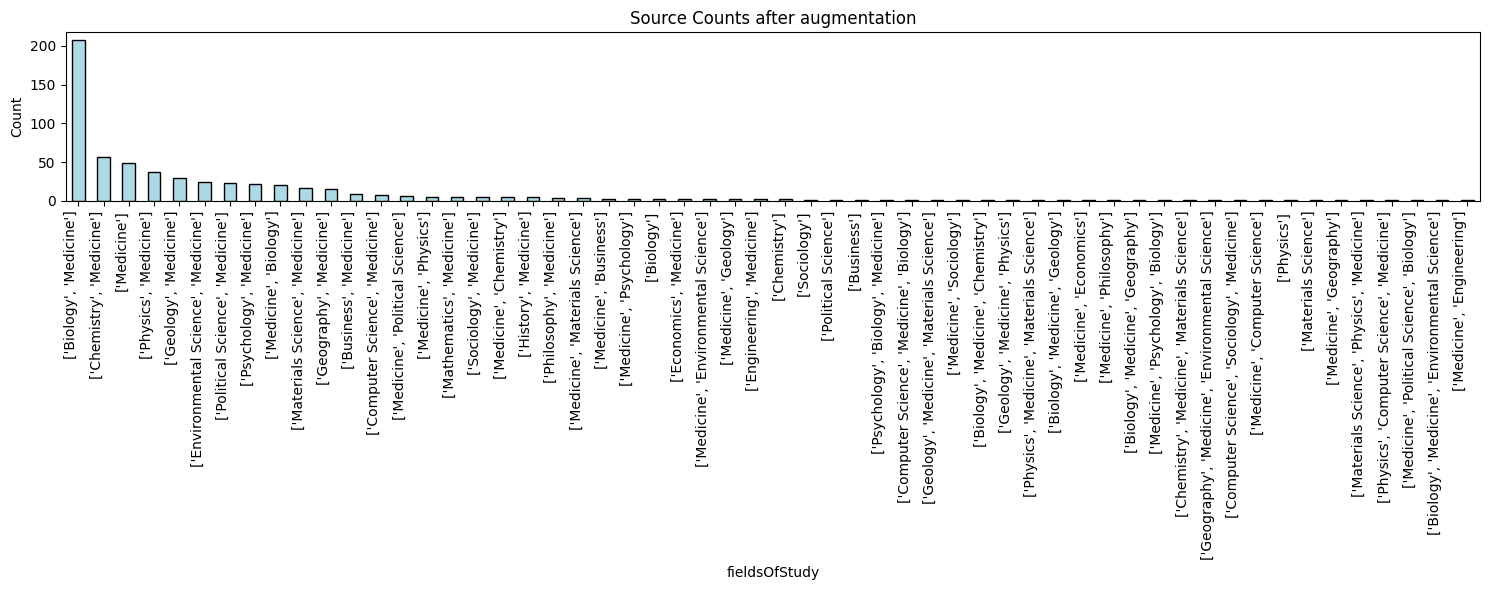

In [22]:
source_counts = df_specific_year['fieldsOfStudy'].value_counts()
####  Optional Graph  ####

# Create a figure and a single axis
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the value counts as a bar chart
source_counts.plot(kind='bar', color='lightblue', edgecolor='black', ax=ax)

# Set the title and labels
ax.set_title('Source Counts after augmentation')
ax.set_ylabel('Count')
ax.set_xticks(range(len(source_counts)))
ax.set_xticklabels(source_counts.index, rotation=90, ha="right")

plt.tight_layout()
plt.show()

# Create Topics

In [24]:
docs = df_specific_year['title_abstract'].tolist()

start_time = time.time()

#model_full = BERTopic(language="english")
model = BERTopic(language="english", n_gram_range = (1, 1), min_topic_size = 24)
topics, probs = model.fit_transform(docs)

print('It took', (time.time()-start_time)/60, 'minutes')

It took 1.8647108872731526 minutes


In [25]:
print(len(df), len(topics), len(probs))

48966 611 611


In [26]:
df_specific_year['topic'] = topics
df_specific_year['probs'] = probs

In [31]:
df_specific_year_2 = df_specific_year[(df_specific_year['topic'] == 1) & (df_specific_year['probs'] > .99)][['title', 'abstract','publicationDate','topic']]
df_specific_year_2 = df_specific_year_2.set_index('publicationDate').sort_index()
display(df_specific_year_2)

,title,abstract,topic
publicationDate,,,
2009-01-16,Coherent Intrachain Energy Migration in a Conjugated Polymer at Room Temperature,The intermediate coupling regime for electronic energy transfer is of particular interest becaus...,1
2009-01-30,Anomalous Criticality in the Electrical Resistivity of La2–xSrxCuO4,The presence or absence of a quantum critical point and its location in the phase diagram of hig...,1
2009-02-13,Pains and Pleasures of Social Life,890 PERSPECTIVES The special nature of the single-electron wave functions required for topologic...,1
2009-02-27,From Oral to Moral,bulk of the sample is not visible in most STM images and is thus typically neglected in the anal...,1
2009-03-06,Dynamic Order-Disorder in Atomistic Models of Structural Glass Formers,The glass transition is the freezing of a liquid into a solid state without evident structural o...,1
2009-03-20,"Giant-Stroke, Superelastic Carbon Nanotube Aerogel Muscles","Improved electrically powered artificial muscles are needed for generating force, moving objects...",1
2009-03-27,Graphene at the Edge: Stability and Dynamics,"Although the physics of materials at surfaces and edges has been extensively studied, the moveme...",1
2009-04-10,Running Droplets of Gallium from Evaporation of Gallium Arsenide,"High-temperature annealing of gallium arsenide in vacuum causes excess evaporation of arsenic, w...",1
2009-05-15,Observing the Quantization of Zero Mass Carriers in Graphene,"Resolving Landau Levels in Graphene The charge carriers in a two-dimensional conductor, when pla...",1
